In [530]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sp
import pickle, time, os
from scipy.special import logsumexp
from copy import deepcopy

In [549]:
def SSH_4orb_NI(k, t1, t2):
    H_NI = np.zeros(shape=(4, 4), dtype=complex)
    H_NI[0, 1] = t1
    H_NI[1, 2] = t2
    H_NI[2, 3] = t1
    H_NI[3, 0] = t2*np.exp(-1j*k)
    return H_NI+np.conj(H_NI.T)

def SSH_2orb_NI(k, t1, t2):
    H_NI = np.zeros(shape=(2, 2), dtype=complex)
    H_NI[0, 1] += t1
    H_NI[1, 0] += t2*np.exp(-1j*k)
    return H_NI+np.conj(H_NI.T)

def get_BZ_points(k_num):
    k_pts_list = []
    for i in range(k_num):
        k_pts_list.append(i*np.pi*2/k_num)
            
    return k_pts_list

def SSH_NI(k, t1, t2, n):
    H_NI = np.zeros(shape=(n, n), dtype=complex)
    for i in range(n-1):
        H_NI[i, (i+1)%n] += (t1 if i%2==0 else t2)*np.exp(-1j*k/2)
        
    H_NI[n-1, 0] += t2*np.exp(-1j*k/2)
    return H_NI+np.conj(H_NI.T)

In [557]:
t1, t2 = 1, 1.5
n_sites = 2


k_pts = 100
k_list = np.linspace(0, 2*np.pi, k_pts)
energy_list = np.zeros(shape=(k_pts, n_sites))
evec_list = np.zeros(shape=(k_pts, n_sites), dtype=complex)
evec_list_2 = np.zeros_like(evec_list)
#evec_list_3 = np.zeros_like(evec_list)

for i, k in enumerate(k_list):
    #hamil = SSH_2orb_NI(k, t1, t2)
    hamil = SSH_NI(k, t1, t2, n_sites)
    evals, evecs = np.linalg.eigh(hamil)
    #print(evecs[:,0])
    idx = np.argsort(evals)
    
    energy_list[i, :] = evals[idx]
    evecs_sorted = evecs[:, idx]
    evec_list[i, :] = evecs_sorted[:, 0]
    evec_list_2[i, :] = evecs_sorted[:, 1]
    #evec_list_3[i, :] = evecs_sorted[:, 2]

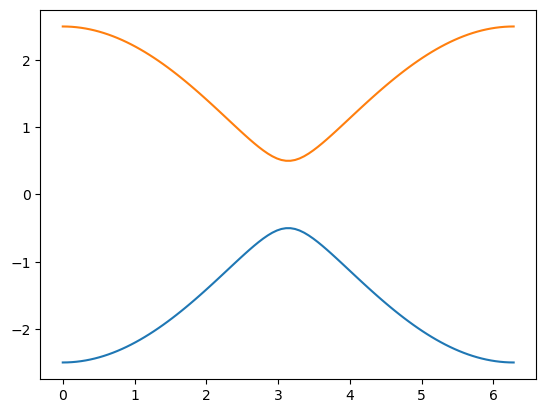

In [558]:
for band in range(n_sites):
    plt.plot(k_list, energy_list[:, band])

In [559]:
prod_list=[]


for i in range(k_pts-1):
#for i in range(k_pts):
    prod_list.append(np.vdot(evec_list[i, :], evec_list[(i+1)%k_pts, :]))
    

prod_list.append(np.vdot(evec_list[k_pts-1, :], evec_list[0, :]))
         
#for i in range(k_pts-1):
#    prod_list.append(np.vdot(evec_list_2[i, :], evec_list_2[i+1, :]))
#                     
#prod_list.append(np.vdot(evec_list_2[k_pts-1, :], evec_list[0, :]))       
    
full_prod = 1
for item in prod_list:
    full_prod*=item

print(np.angle(full_prod)/np.pi)


-6.416521259443644e-18


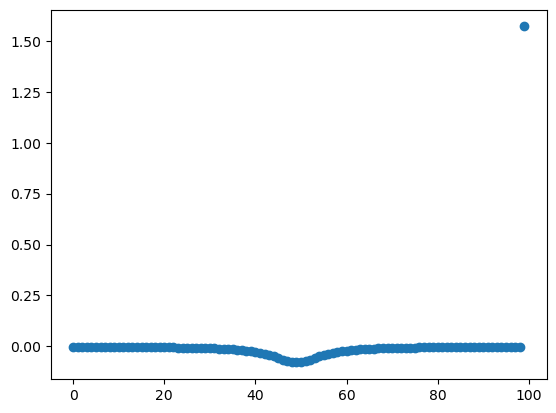

In [560]:
plt.plot(np.angle(np.array(prod_list)), marker='o', linestyle='')
#plt.ylim(0, 0.25)

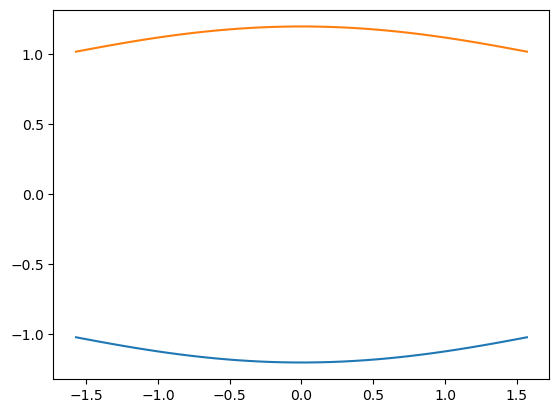

In [286]:
t1, t2 = 1, 0.2

k_pts = 40
k_list = np.linspace(-np.pi/2, np.pi/2, k_pts)
energy_list = np.zeros(shape=(k_pts, 2))

for i, k in enumerate(k_list):
    hamil = SSH_2orb_NI(k, t1, t2)
    evals, evecs = np.linalg.eigh(hamil)
    
    energy_list[i, :] = np.sort(evals)
    
    
for band in range(2):
    plt.plot(k_list, energy_list[:, band])

In [458]:


os.environ["OMP_NUM_THREADS"] = "12"     # or the number of physical cores you have
os.environ["MKL_NUM_THREADS"] = "12"     # same variable if you use MKL


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = n_sites  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [503]:
import numpy as np
import scipy.sparse as sp

def fixed_particle_subspace_indices(N, Np):
    """
    Return the indices of basis states with Np particles.
    """
    basis_indices = []
    for i in range(2**N):
        if bin(i).count("1") == Np:
            basis_indices.append(i)
    return np.array(basis_indices, dtype=int)

def projector_to_N_sector(N, Np):
    """
    Sparse projector onto the Np-particle sector for N orbitals.
    """
    indices = fixed_particle_subspace_indices(N, Np)
    dim_full = 2**N
    P = sp.csr_matrix((np.ones_like(indices, dtype=complex),
                       (indices, np.arange(len(indices)))),
                      shape=(dim_full, len(indices)))
    return P

def project_to_sector(H, P):
    """
    Project operator H to subspace defined by P.
    """
    return P.conj().T @ (H @ P)


In [502]:
def hamil(t1, mu, U, t2, k):
    hamiltonian = sp.csr_matrix((2**N, 2**N), dtype=complex)
    NN_ham_mat= SSH_NI(k, t1, t2, n_sites)
    for i in range(N):
        for j in range(i+1, N):
            if NN_ham_mat[i,j] ==0: continue
            hamiltonian+=cdags[i]@cs[j]*NN_ham_mat[i,j] + cdags[j]@cs[i]*NN_ham_mat[j, i]
            hamiltonian+=cdags[i]@cs[i]@cdags[j]@cs[j]*U
    for i in range(N):
        hamiltonian+=-(mu)*(cdags[i]@cs[i])
    
    return hamiltonian

def n_filled(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op@ evecs*np.exp(-beta*evals)).real.sum()/Z0


def n_filled_stable(H_csr, beta, num_op):
    #evals, evecs = full_diag_dense(H_csr)
    evals, evecs = sp.linalg.eigsh(H_csr, k=4, which='SA')
    logw = -beta * evals                       # log-weights

    Ndiag = np.diag(evecs.T.conj() @ num_op @ evecs).real
    log_num = logsumexp(logw, b=Ndiag)         # log Σ e^{-βE_i} N_ii
    log_den = logsumexp(logw)                  # log Z

    return np.exp(log_num - log_den)


def n_filled2(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op2@ evecs*np.exp(-beta*evals)).real.sum()/Z0

def n_filled_tot(t1, mu, U, t2, beta, k_num):
    acc = 0
    for k in get_BZ_points(k_num):
        hamil_k = hamil(t1, mu, U, t2, k)
        #H = np.asfortranarray(hamil_k.toarray(order='F')) 
        acc+=n_filled_stable(hamil_k, beta, num_op)
    return acc/k_num

In [460]:
num_op = sp.csr_matrix((2**N, 2**N), dtype=complex)
for i in range(N):
    num_op+=cdags[i]@cs[i]

In [507]:
Np = N - 2

# suppose you already have H_full
P = projector_to_N_sector(N, Np)
H_proj = project_to_sector(num_op, P)

evals, _ = sp.linalg.eigsh(H_proj, k=4,which='SA')

evals

array([2., 2., 2., 2.])

In [508]:
k_num = 20

t1 = 1
t2 = 1.5

U_list = np.array([4])
beta_list = np.array([100])
n_mu_pts = 40

filling_list = np.zeros(shape=(len(U_list), len(beta_list), n_mu_pts))

for U_ind, U in enumerate(U_list):
    print(U)
    for beta_ind, beta in enumerate(beta_list):
        mu_list = np.linspace(-2, 10, n_mu_pts)
        for mu_ind, mu in enumerate(mu_list):
            filling_list[U_ind, beta_ind, mu_ind] = n_filled_tot(t1, mu, U, t2,  beta, k_num)
            print(mu_ind)

4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


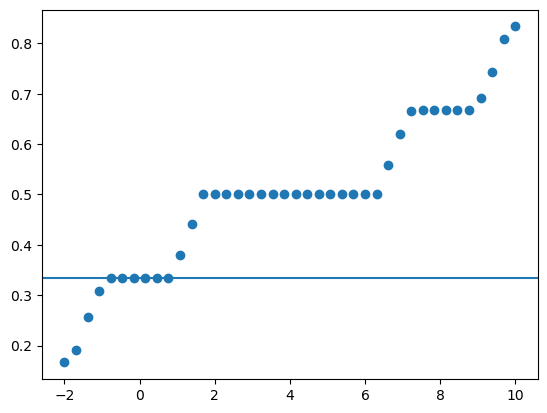

In [509]:
plt.scatter(mu_list, filling_list[0,0,:]/n_sites)
plt.axhline(y=0.3333)
#plt.axhline(y=0.25)

In [526]:
U = 4
beta = 100
mu = 0
k_num = 100

N_eigs = 6

energies = np.zeros(shape=(k_num, N_eigs))
#evec_list = np.zeros(shape=(k_num, 2**N), dtype=complex)
evec_list = np.zeros(shape=(k_num, 15), dtype=complex)
evec_list_2 = np.zeros_like(evec_list)
evec_list_3 = np.zeros_like(evec_list)
k_list = get_BZ_points(k_num)


for i, k in enumerate(k_list):
    hamil_k = project_to_sector(hamil(t1, mu, U, t2,  k), P)
    evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
    energies[i, :] = np.sort(evals)
    
    idx = np.argsort(evals)
    
    evecs_sorted = evecs[:, idx]
    evec_list[i, :] = evecs_sorted[:, 0]
    evec_list_2[i, :] = evecs_sorted[:, 1]
    evec_list_3[i, :] = evecs_sorted[:, 2]

In [493]:
prod_list=[]


for i, k in enumerate(k_list):
    prod_list.append(np.vdot(evec_list[i, :], evec_list[(i+1)%k_num, :]))

full_prod = 1
for item in prod_list:
    full_prod*=item

    
print((np.angle(full_prod)/np.pi)%1)

0.3018845601626785


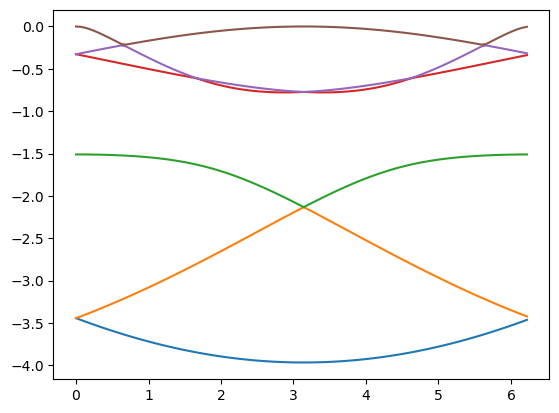

In [527]:
for i in range(N_eigs):
    plt.plot(get_BZ_points(k_num), energies[:, i])
    
    
#plt.ylim(-4.5, -1)

In [528]:
prod_list=[]

for i in range(k_num-1):
    prod_list.append(np.vdot(evec_list[i, :], evec_list[(i+1)%k_num, :]))
    
prod_list.append(np.vdot(evec_list[k_num-1, :], evec_list_2[0, :]))

for i in range(0, int(k_num/2)):
    prod_list.append(np.vdot(evec_list_2[i, :], evec_list_2[(i+1)%k_num, :]))

prod_list.append(np.vdot(evec_list_2[k_num//2, :], evec_list_3[k_num//2 + 1, :]))
    
for i in range(k_num//2 + 1, k_num//2 + k_num):
    prod_list.append(np.vdot(evec_list_3[i%k_num, :], evec_list_3[(i+1)%k_num, :]))
    
prod_list.append(np.vdot(evec_list_3[k_num//2, :], evec_list_2[k_num//2 + 1, :]))

for i in range(k_num//2 + 1, k_num):
    prod_list.append(np.vdot(evec_list_2[i, :], evec_list_2[(i+1)%k_num, :]))
    
prod_list.append(np.vdot(evec_list_2[k_num-1, :], evec_list[0, :]))

In [529]:
full_prod = 1
for item in prod_list:
    full_prod*=item
    
print((np.angle(full_prod)/np.pi))

0.5812135745286231


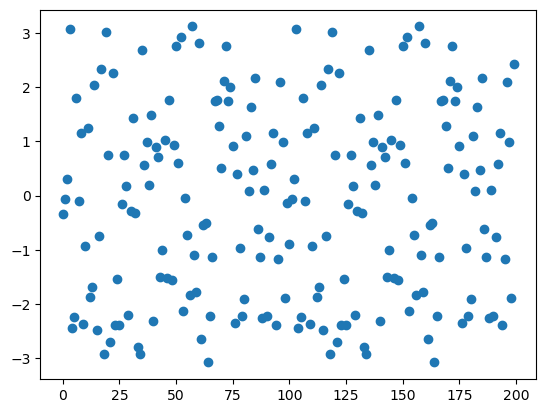

In [500]:
plt.plot(np.angle(np.array(prod_list)), marker='o', linestyle='')

In [395]:
from copy import deepcopy

try_list = np.angle(np.array(prod_list))
temp_evecs = deepcopy(evec_list)